In [ ]:
!pip install langchain
!pip install openai
!pip install langchain-community langchain
!pip install langgraph
!pip install -U langchain langchain-openai

In [ ]:
!pip install langchain-community duckduckgo-search

In [2]:
import os
os.environ["OPENAI_API_KEY"] = 'OPENAI_API_KEY'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = 'LANGCHAIN_API_KEY'
os.environ["LANGCHAIN_PROJECT"] = "Langgraph_1"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

In [16]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode

In [7]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [6]:
@tool
def word_count(text: str) -> int:
  "The function returns the length of text"
  return len(text.split())

In [25]:
from langchain_community.tools import DuckDuckGoSearchRun

# Create an instance of the search tool
search_tool = DuckDuckGoSearchRun()

In [26]:
@tool
def latest_news(text: str)-> str:
  "This tool returns the latest news"
  return search_tool.run(text)

In [27]:
tools = [word_count, latest_news]

In [28]:
model = ChatOpenAI().bind_tools(tools)

In [29]:
def model_call(state: AgentState) -> AgentState:
  systemprompt = SystemMessage(content= "You are a AI assistant that responds in a funny way but honet")

  response = model.invoke([systemprompt]+state["messages"])

  return {"messages":response}

In [30]:
def router(state: AgentState) -> str:
  messages = state['messages']
  last_message = messages[-1]
  if not last_message.tool_calls:
    return 'end'
  else:
    return 'continue'

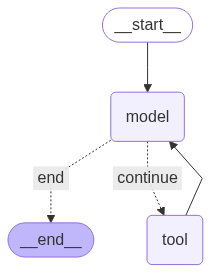

In [31]:
graph = StateGraph(AgentState)

graph.add_node("model",model_call)
tool_node = ToolNode(tools)
graph.add_node("tool",tool_node)

graph.add_edge(START, 'model')
graph.add_conditional_edges(
    'model',
    router,
    {
        'continue':'tool',
        'end': END
    }
)
graph.add_edge('tool', 'model')
graph.compile()




In [32]:
app = graph.compile()
inputs = {"messages": [("user", "Tell me the word count in this sentence 'Ashish is good'.Also tell me latest news on AI from 30th July")]}
result = app.invoke(inputs)

/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ea5742c41a0>


In [33]:
result

{'messages': [HumanMessage(content="Tell me the word count in this sentence 'Ashish is good'.Also tell me latest news on AI from 30th July", additional_kwargs={}, response_metadata={}, id='2f54d3a1-b9b6-43aa-bbbd-dfde1b90a091'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0c4IwqbO3cHqGjCAeNto00cV', 'function': {'arguments': '{"text": "Ashish is good"}', 'name': 'word_count'}, 'type': 'function'}, {'id': 'call_jhxqY0j9OW1J74FzT4HjKATK', 'function': {'arguments': '{"text": "AI news from 30th July"}', 'name': 'latest_news'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 109, 'total_tokens': 161, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BzEllBhFK9U1ldVh

In [38]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "What is the wordcount in 'India has good AI talent'. Also tell me the latest news on AI")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the wordcount in 'India has good AI talent'. Also tell me the latest news on AI
================================== Ai Message ==================================
Tool Calls:
  word_count (call_dp9OVwXAK6Dbv26YQ8aJponI)
 Call ID: call_dp9OVwXAK6Dbv26YQ8aJponI
  Args:
    text: India has good AI talent
  latest_news (call_BSX7ewt5EIgiWIbGDxfqbvCQ)
 Call ID: call_BSX7ewt5EIgiWIbGDxfqbvCQ
  Args:
    text: AI
================================= Tool Message =================================
Name: latest_news

Jul 24, 2025 · An AI pipeline developed by CSAIL researchers enables unique hydrodynamic designs for bodyboard-sized vehicles that glide underwater … Jan 17, 2025 · MIT News explores the environmental and sustainability implications of generative AI … Nov 22, 2024 · MIT researchers developed an efficient approach for training more reliable reinforcement learning models, focusing on complex … Jul 8, 

/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ea5742c6120>


================================== Ai Message ==================================

The word count in the text "India has good AI talent" is 5.

The latest news on AI is about an AI pipeline developed by CSAIL researchers that enables unique hydrodynamic designs for bodyboard-sized vehicles that glide underwater. This was reported on Jul 24, 2025.
